In [19]:
!python --version

Python 3.11.7


In [ ]:
%%capture

# The environment we will be working with
%pip install CityLearn==2.1.2

# For participant interactions (buttons)
%pip install ipywidgets

# To generate static figures
%pip install matplotlib
%pip install seaborn

# Provide standard RL algorithms
%pip install stable-baselines3

# Enable gym compatibility with later stable-baselines3 versions
%pip install shimmy

# Results submission
%pip install requests
%pip install beautifulsoup4

In [ ]:
import sys, subprocess
print("Python:", sys.executable)
print("Pip:   ", subprocess.run(["which","pip"], capture_output=True, text=True).stdout)

# System operations
import os

# Type hinting
from typing import Any, List, Mapping, Tuple, Union

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

import import_ipynb

# Data manipulation
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import torch as th

# CityLearn
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction, SolarPenaltyReward

# Baseline RL algorithms
from stable_baselines3 import SAC
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecMonitor, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback, CallbackList
from stable_baselines3.common.monitor import Monitor


# set all plotted figures without margins
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
%matplotlib inline

Python: /hkfs/home/haicore/iai/cj9272/citylearn_env/bin/python
Pip:    /software/all/jupyter/ai/2025-05-23/bin/pip



In [ ]:
# Dataset
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'
schema = DataSet().get_schema(DATASET_NAME)
print(schema['root_directory'])

# Building
#root_directory = schema['root_directory']
root_directory = 'Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
building_name = 'Building_1'
# Weather data
filename = schema['buildings'][building_name]['weather']
filepath = os.path.join(root_directory, filename)
weather_data = pd.read_csv(filepath)
# Pricing data (simple)
filename = schema['buildings'][building_name]['pricing']
filepath = os.path.join(root_directory, filename)
pricing_data = pd.read_csv(filepath)
# Carbon Intensity data
filename = schema['buildings'][building_name]['carbon_intensity']
filepath = os.path.join(root_directory, filename)
carbon_intensity_data = pd.read_csv(filepath)
# building data
filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
building_data = pd.read_csv(filepath)

# Display building data
# display(building_data.head())
# display(building_data.describe(include='all'))

bld = building_data.copy()
wth = weather_data.copy()
prc = pricing_data.copy()
car = carbon_intensity_data.copy()

print(building_data.columns.tolist())

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1
['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 'indoor_dry_bulb_temperature_cooling_set_point', 'indoor_dry_bulb_temperature_heating_set_point', 'hvac_mode']


In [ ]:
observations = [
    # building_df
    'month', 'hour', 'day_type', 'daylight_savings_status',
    'indoor_dry_bulb_temperature',
    'average_unmet_cooling_setpoint_difference',
    'indoor_relative_humidity',
    'non_shiftable_load', 'dhw_demand',
    'cooling_demand', 'heating_demand',
    'solar_generation', 'occupant_count',
    'indoor_dry_bulb_temperature_cooling_set_point',
    'indoor_dry_bulb_temperature_heating_set_point', 'hvac_mode',
    # weather_df
    'outdoor_dry_bulb_temperature',
    'outdoor_relative_humidity',
    'diffuse_solar_irradiance',
    'direct_solar_irradiance',
    'outdoor_dry_bulb_temperature_predicted_1',
    'outdoor_dry_bulb_temperature_predicted_2',
    'outdoor_dry_bulb_temperature_predicted_3',
    'outdoor_relative_humidity_predicted_1',
    'outdoor_relative_humidity_predicted_2',
    'outdoor_relative_humidity_predicted_3',
    'diffuse_solar_irradiance_predicted_1',
    'diffuse_solar_irradiance_predicted_2',
    'diffuse_solar_irradiance_predicted_3',
    'direct_solar_irradiance_predicted_1',
    'direct_solar_irradiance_predicted_2',
    'direct_solar_irradiance_predicted_3',
    # carbon_df 
    'carbon_intensity',
    # pricing_df
    'electricity_pricing',
    'electricity_pricing_predicted_1',
    'electricity_pricing_predicted_2',
    'electricity_pricing_predicted_3'
]
bld_cols = [
            'month', 'hour', 'day_type', 'daylight_savings_status',
            'indoor_dry_bulb_temperature',
            'average_unmet_cooling_setpoint_difference',
            'indoor_relative_humidity', 'non_shiftable_load',
            'dhw_demand', 'cooling_demand', 'heating_demand',
            'solar_generation', 'occupant_count',
            'indoor_dry_bulb_temperature_cooling_set_point',
            'indoor_dry_bulb_temperature_heating_set_point',
            'hvac_mode'
]
wth_cols = [
    'outdoor_dry_bulb_temperature',
    'outdoor_relative_humidity',
    'diffuse_solar_irradiance',
    'direct_solar_irradiance'
]

### Deep Q-Learning Agent
#### 1. Reward Function


In [ ]:
class CustomReward(RewardFunction):
    def __init__(self, capacity: float):
        self.capacity = capacity
        self.prev_net_load = None

    def __call__(self, obs: Mapping[str, float], action_frac: float) -> float:
        # 1) Net load & cost
        net_load   = obs['non_shiftable_load'] - action_frac*self.capacity # max: 11.25 kW
        price = obs['electricity_pricing'] # 0.06605 or 0.03025
        cost  = max(0.0, net_load) * price # deviation range: 0-11.25*0.06605 = ~0-0.75$
        #norm_cost = cost / 0.75 # normalize to [0,1]

        # return -(w_cost*cost + w_pen*comfort_penalty + w_emis*emis + w_ramp*ramp)        
        return -cost

#### 2. Environment
I wrap the DataFrames in a Gym Environment
following the same pattern as the tutorial’s Tabular QL wrapper,
but here I implement a custom `gym.Env` that emits a vector of normalized
features and accepts a *discrete* charge/discharge action.


In [ ]:
from citylearn.reward_function import ComfortReward


class CityLearnDQNEnv(gym.Env):
    def __init__(self,
                 building_df: pd.DataFrame,
                 pricing_df:  pd.DataFrame,
                 weather_df:  pd.DataFrame,
                 carbon_df:   pd.DataFrame,
                 n_bins:      int = 5):
        super().__init__()
        # Data
        self.bld = building_df.reset_index(drop=True)
        self.prc = pricing_df.reset_index(drop=True)
        self.wth = weather_df.reset_index(drop=True)
        self.car = carbon_df.reset_index(drop=True)
        self.T   = len(self.bld) # number of timesteps in one episode = 2208

        self.n_bins     = n_bins
        self.action_space = spaces.Discrete(n_bins)

        # Observation space params
        self.obs_cols = observations
        self.obs_amount = len(self.obs_cols)
        self.bound = 5.0  # clip extreme outliers to ±5σ (cover 99.99994% of value)
        low  = -np.ones(self.obs_amount, dtype=np.float32) * self.bound
        high =  np.ones(self.obs_amount, dtype=np.float32) * self.bound

        # Observation space: Box of params, with every param having mean 0, std 1, bounds [-5, 5]
        self.observation_space = spaces.Box(low, high, dtype=np.float32)

        # Compute mean and std for each feature
        all_obs = pd.concat([
            self.bld[bld_cols],
            self.wth[wth_cols],
            self.car[['carbon_intensity']],
            self.prc[['electricity_pricing']]
        ], axis=1)
        self.obs_mean = all_obs.mean().values.astype(np.float32)
        self.obs_std  = all_obs.std().values.astype(np.float32)

        # Simple battery
        self.capacity = 1.0
        self.soc      = 0.5
        
        # Set Reward function
        #self.reward_fn = CustomReward(capacity=self.capacity)
        self.reward_fn = ComfortReward(env_metadata=schema, band=2.0, lower_exponent=2, higher_exponent=2)

    def reset(self, seed=None, options=None):
        # Set seed if passed
        if seed is not None:
            self.np_random, _ = gym.utils.seeding.np_random(seed) # reproducable randomness, not used yet TODO
        self.t   = 0
        self.soc = 0.5
        info = {}
        return self._get_obs(), info

    def _get_obs(self):
        bld_row = self.bld.iloc[self.t]
        wth_row = self.wth.iloc[self.t]
        car_val = self.car.loc[self.t, 'carbon_intensity']
        prc_val = self.prc.loc[self.t, 'electricity_pricing']
        
        row = pd.concat([
            bld_row[bld_cols],
            wth_row[wth_cols],
            pd.Series({'carbon_intensity': car_val}),
            pd.Series({'electricity_pricing': prc_val})
        ])

        obs_dict = row[[
        'heating_demand',
        'cooling_demand',
        'hvac_mode',
        'indoor_dry_bulb_temperature',
        'indoor_dry_bulb_temperature_cooling_set_point',
        'indoor_dry_bulb_temperature_heating_set_point'
        ]].to_dict()
        obs_dict['carbon_intensity']    = float(self.car.loc[self.t, 'carbon_intensity'])
        obs_dict['electricity_pricing'] = float(self.prc.loc[self.t, 'electricity_pricing'])

        
        x = np.array([row[c] for c in self.obs_cols], dtype=np.float32)
        
        # Calculate z-score normalization (mean=0, std=1) and clip to ±5std
        #z = (x - self.obs_mean) / self.obs_std
        #np.clip(x, -5.0, 5.0, out=x)
        
        return obs_dict, x

    def step(self, action):
        # Action → fraction of charge/discharge
        frac = -1.0 + 2.0 * (action / (self.n_bins - 1)) # action [0, n] -> charge/discharge [-1, 1]

        # SoC-Update
        self.soc = float(np.clip(self.soc + 0.1 * frac,
                                 0.0, self.capacity))

        # Observation to dict
        obs_dict = {c: self.bld.loc[self.t, c] for c in [
            'non_shiftable_load',
            'indoor_dry_bulb_temperature',
            'indoor_relative_humidity',
        ]}
        obs_dict['electricity_pricing'] = float(self.prc.loc[self.t, 'electricity_pricing'])
        obs_dict['carbon_intensity'] = float(self.car.loc[self.t, 'carbon_intensity'])
        
        obs_dicT = self._get_obs()
        print(f"manual creation: {obs_dict}")
        print(f"function: {obs_dicT}")

        reward_list = self.reward_fn.calculate(observations=[obs_dicT])
        # reward = self.reward_fn.calculate(obs_dict) # Citylearn SolarPenaltyReward 
        reward = float(reward_list[0])

        # Increase time and get next observation array
        self.t += 1
        terminated = (self.t >= self.T) # after 2208 timesteps one episode is done
        truncated = False  # no time limit
        obs = self._get_obs() if not terminated else np.zeros(len(self.obs_cols), dtype=np.float32)
        info = {}
        return obs, reward, terminated, truncated, info

    def render(self, mode='human'): pass

In [ ]:
class TrainLoggerCallback(BaseCallback):
    """Logging State, Action, Reward per step and Loss per update phase."""
    def __init__(self, verbose=0):
        super().__init__(verbose)
        # Will collect a dict per env-step
        self.rows = []
        # Loss values and their timesteps (global)
        self.losses = []
        self.loss_timesteps = []
        # Completed episode returns (global list)
        self.episode_rewards = []
        # Placeholders for per-env tracking
        self._current_ep_rewards = []         # sum of rewards in current episode per env
        self._current_ep_counts = []          # episode index per env
        self._current_step_in_episode = []    # step counter (0..T-1) per env

        # DataFrames to populate at end
        self.df = pd.DataFrame()
        self.ep_df = pd.DataFrame()

    def _on_training_start(self) -> None:
        try:
            n_envs = self.training_env.num_envs
        except AttributeError:
            n_envs = 1
        # initialize counters per sub-env
        self._current_ep_rewards = [0.0] * n_envs
        self._current_ep_counts = [1] * n_envs
        self._current_step_in_episode = [0] * n_envs
        super()._on_training_start()

    def _on_step(self) -> bool:
        obs_vec = self.locals.get("new_obs")
        acts    = self.locals.get("actions")
        rews    = self.locals.get("rewards")
        dones   = self.locals.get("dones")
        step    = int(self.num_timesteps)

        # log loss if present
        loss_val = self.logger.name_to_value.get("train/loss")
        if loss_val is not None:
            self.losses.append(float(loss_val))
            self.loss_timesteps.append(step)

        # iterate each sub-env
        for idx, (obs, act, rew, done) in enumerate(zip(obs_vec, acts, rews, dones)):
            # flatten observation
            flat = obs.flatten().tolist()
            # build row with metadata
            row = {f"x{i}": flat[i] for i in range(len(flat))}
            row.update({
                "env_id": idx,
                "episode": self._current_ep_counts[idx],
                "step_in_ep": self._current_step_in_episode[idx],
                "action": int(act),
                "reward": float(rew),
                "global_step": step
            })
            self.rows.append(row)

            # accumulate per-episode reward
            self._current_ep_rewards[idx] += float(rew)
            # increment step in episode
            self._current_step_in_episode[idx] += 1

            # if end of episode for this env
            if done:
                # log reward and finalize episode
                print(f"Env {idx} Episode {self._current_ep_counts[idx]} done at global step {step}, total reward: {self._current_ep_rewards[idx]:.3f}")
                self.episode_rewards.append(self._current_ep_rewards[idx])
                # reset for next episode
                self._current_ep_rewards[idx] = 0.0
                self._current_ep_counts[idx] += 1
                self._current_step_in_episode[idx] = 0

        return True

    def _on_training_end(self) -> None:
        # build full-step DataFrame
        self.df = pd.DataFrame(self.rows)
        # build episodes summary DataFrame
        self.ep_df = pd.DataFrame({
            "episode_global": range(1, len(self.episode_rewards) + 1),
            "return": self.episode_rewards
        })
        super()._on_training_end()

In [ ]:
def make_env(idx):
    def _init():
        env = CityLearnDQNEnv(
            building_df=bld,
            pricing_df=prc,
            weather_df=wth,
            carbon_df=car,
            n_bins=5
        )
        return Monitor(env)  # record episode stats
    return _init

# Launch parallel environments
n_envs = 3
train_env = SubprocVecEnv([make_env(i) for i in range(n_envs)])
train_env = VecMonitor(train_env)
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

# Single-process eval env wrapped in Monitor
eval_env = DummyVecEnv([lambda: Monitor(CityLearnDQNEnv(building_df=bld, pricing_df=prc, weather_df=wth, carbon_df=car, n_bins=5))])
eval_env = VecMonitor(eval_env) 
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

# Evaluate every 2k steps over 5 episodes
eval_callback = EvalCallback(
    eval_env,
    log_path="logs/eval/",
    best_model_save_path="logs/best_model/",
    #eval_freq=len(building_data), # run evaluation every 5k timesteps, TODO: change to 5_000
    eval_freq=1000, # run evaluation every n timesteps, TODO: change n to 5_000
    n_eval_episodes=5,       # average over 5 full episodes
    deterministic=True,
    verbose=1
)

train_callback = TrainLoggerCallback()

model = DQN(
    policy='MlpPolicy',
    env=train_env,
    learning_rate=3e-4, # slower to stabilize training
    buffer_size=100_000, 
    batch_size=128, 
    learning_starts=2_000, # start learning after 2000 steps, so enough experience is collected in replay-buffer
    train_freq= 256, # update the model every 256 steps
    target_update_interval= 500, # update the target network every 500 steps to avoid bull-whip effects (increasing oscillations)
    exploration_fraction= 0.3, # longer exploration until epsilon sinks to min value
    exploration_initial_eps= 1.0, # start with 100% exploration
    exploration_final_eps= 0.02, # near deterministic policy at the end
    gamma=0.98, # how much future rewards are discounted, 0.98 = 2% discount
    verbose=1, # 1 = info, 2 = debug
    policy_kwargs=dict(
        net_arch=[256, 256, 256],
        activation_fn=th.nn.ReLU,
        #dueling=True,
    ),
) 

# Model training
T = len(building_data) # 1 episode = 2208 timesteps
num_episodes = 10 # 10 episodes
model.learn(
    total_timesteps=n_envs * num_episodes * T,
    callback=CallbackList([train_callback, eval_callback])
)

print("Eval timesteps:", eval_callback.evaluations_timesteps)
print("Eval results   :", eval_callback.evaluations_results)


print("---------------Train callback: \n", train_callback.df)
print("---------------Episode rewards: \n", train_callback.ep_df)


# Evaluation results
all_rewards = eval_callback.evaluations_results # List of lists: each element are rewards from an eval round
eval_steps  = eval_callback.evaluations_timesteps # timesteps at which the evaluations were run

# Mean reward per round
mean_rewards = [np.mean(r) for r in all_rewards]

2025-08-14 06:39:43.955619: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 06:39:43.968276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755146383.980360 2566546 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755146383.984174 2566546 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755146383.995298 2566546 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using cuda device
Couldn't import dot_parser, loading of dot files will not be possible.
Couldn't import dot_parser, loading of dot files will not be possible.
Couldn't import dot_parser, loading of dot files will not be possible.


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
Process ForkServerProcess-5:
Process ForkServerProcess-4:
Process ForkServerProcess-6:
Traceback (most recent call last):
  File "/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pand

EOFError: 

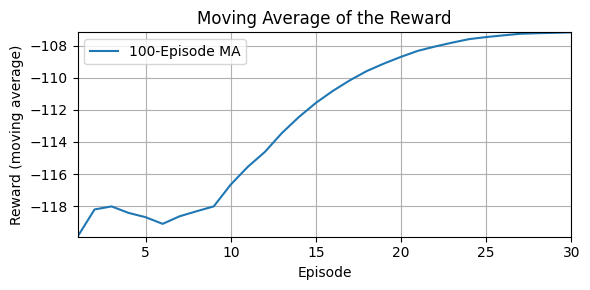

Total episodes: 30


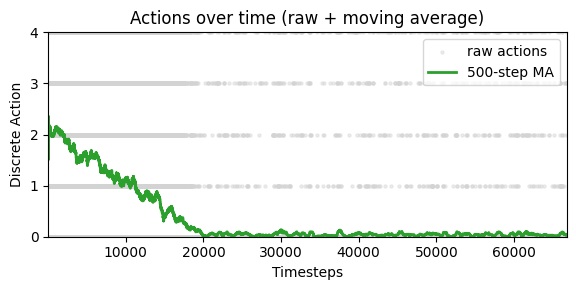

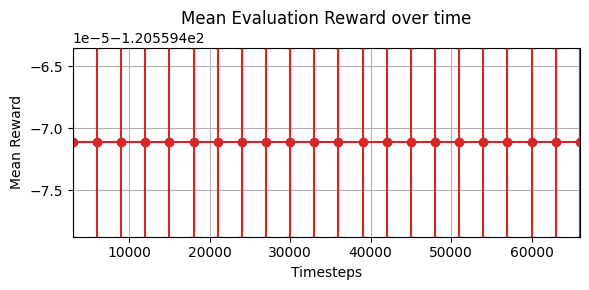

: 

In [ ]:
# Training reward
window = 100
smooth = train_callback.ep_df["return"].rolling(window, min_periods=1).mean()
#train_df = train_callback.df  # your TrainLoggerCallback should have produced this
plt.figure(figsize=(6, 3))
plt.plot(train_callback.ep_df["episode_global"], smooth, label=f"{window}-Episode MA", color="C0")
#plt.plot(train_df["step"], train_df["reward"], color="C0")
plt.title("Moving Average of the Reward")
plt.xlabel("Episode")
plt.ylabel("Reward (moving average)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
n_episodes = len(train_callback.ep_df)
print(f"Total episodes: {n_episodes}")
"""
# Training loss (if available)
if hasattr(train_callback, "losses") and len(train_callback.losses) > 0:
    plt.figure(figsize=(6, 3))
    plt.plot(train_callback.loss_timesteps,
             train_callback.losses,
             marker='.', linestyle='-',
             alpha=0.7, color="C1")
    plt.title("Train Loss over time")
    plt.xlabel("Timesteps")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
"""
train_df = train_callback.df  

# Actions (raw + moving average)
plt.figure(figsize=(6, 3))
# raw scatter
plt.scatter(
    train_df["global_step"],
    train_df["action"],
    c="lightgray", s=5, alpha=0.4,
    label="raw actions"
)
# moving average
window = 500
train_df["action_ma"] = train_df["action"].rolling(window, min_periods=1).mean()
plt.plot(
    train_df["global_step"],
    train_df["action_ma"],
    color="C2", lw=2,
    label=f"{window}-step MA"
)
plt.title("Actions over time (raw + moving average)")
plt.xlabel("Timesteps")
plt.ylabel("Discrete Action")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Evaluation results
all_eval = eval_callback.evaluations_results        # list of lists
steps    = eval_callback.evaluations_timesteps      # list of ints

# Compute per‐evaluation mean/std
mean_eval = [float(np.mean(r)) for r in all_eval]
std_eval  = [float(np.std(r))  for r in all_eval]

plt.figure(figsize=(6, 3))
plt.errorbar(
    steps, mean_eval,
    yerr=std_eval,
    fmt='-o', capsize=3, color="C3",
    label="Eval mean ±1σ"
)
plt.title("Mean Evaluation Reward over time")
plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.grid(True)
plt.tight_layout()
plt.show()